In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
 
np.random.seed(42)

C:\Users\tony3\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\tony3\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\tony3\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\tony3\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
retail_df = pd.read_csv('Retail_Transaction_Dataset.csv')
retail_df = pd.read_csv('Retail_Transaction_Dataset.csv', parse_dates=['TransactionDate'])
retail_df = retail_df.sample(frac=0.2) # runtime optimized

In [4]:
retail_df

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
75721,589267,B,9,39.435470,2023-12-25 08:52:00,Credit Card,"74456 Hannah Corners\nKellyshire, MT 56421",Clothing,4.133846,340.247412
80184,984728,B,5,30.725078,2024-04-04 19:47:00,PayPal,"7232 Gregory Lake\nTerrellmouth, MS 28977",Clothing,10.191359,137.968874
19864,843790,C,3,52.491217,2024-03-07 16:39:00,Credit Card,"462 Stephanie Freeway\nOdonnellview, PW 86506",Books,11.401557,139.519204
76699,9344,D,6,79.395876,2024-04-16 15:38:00,Debit Card,"8010 Clark Point\nNew Alexanderberg, HI 10374",Electronics,10.308317,427.268985
92991,92751,D,7,95.561580,2024-03-18 04:21:00,PayPal,"08325 Welch Divide\nAliciahaven, DC 84486",Clothing,7.499713,618.763148
...,...,...,...,...,...,...,...,...,...,...
32595,828703,C,4,74.797255,2024-02-03 22:05:00,Credit Card,"0846 Campbell Forges Apt. 632\nHollandburgh, C...",Clothing,6.340242,280.219711
29313,581833,C,7,42.307755,2023-12-02 03:43:00,Credit Card,"99042 Katherine Square\nLawsonberg, NE 28073",Books,12.942842,257.823505
37862,449404,C,6,12.688836,2023-10-27 15:14:00,PayPal,"98240 Ronald Landing Apt. 790\nPort Gracefurt,...",Electronics,19.259591,61.470107
53421,847983,B,6,13.507113,2023-07-06 17:16:00,Debit Card,"9401 Nicole Run Apt. 795\nWadeberg, NC 83685",Electronics,17.788677,66.626258


In [7]:
# Preparing dataset by adding competitor pricing data, promotional data, seasonal data
# competitor pricing simulation with Monte Carlo method

def simulate_competitor_pricing(prices, volatility=0.1):
    competitor_prices = prices * np.random.normal(1, volatility, len(prices))
    return np.round(competitor_prices,2)

# seasonal factor simulation 
def simulate_seasonal_factors(df, date_col='TransactionDate', quantity_col='Quantity'):
    df = df.copy()
    
    monthly = (
        df
        .set_index(date_col)[quantity_col]
        .resample('M')
        .sum()
        .asfreq('M', fill_value=0)
    )

    decomp = sm.tsa.seasonal_decompose(monthly, model='multiplicative', period=4) 
    s = decomp.seasonal
    z = (s - s.mean()) / s.std()
    
    # Define bins: z ≤ -1 → Low, |z| < 1 → Medium, z ≥ 1 → High
    cut_labels = pd.cut(z, bins=[-float('inf'), -1, 1, float('inf')], labels=['Low','Medium','High'])
    month_label = {m: cut_labels.loc[idx] for idx, m in zip(cut_labels.index, cut_labels.index.month)}


    return df[date_col].dt.month.map(lambda m: month_label.get(m, 'Medium'))


In [9]:
retail_df['Competitor Price'] = simulate_competitor_pricing(retail_df['Price'])
retail_df['Seasonal Factor'] = simulate_seasonal_factors(retail_df)
retail_df.drop(columns=['StoreLocation'], inplace=True) 
retail_df


,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,ProductCategory,DiscountApplied(%),TotalAmount,Competitor Price,Seasonal Factor
75721,589267,B,9,39.435470,2023-12-25 08:52:00,Credit Card,Clothing,4.133846,340.247412,42.73,High
80184,984728,B,5,30.725078,2024-04-04 19:47:00,PayPal,Clothing,10.191359,137.968874,31.19,High
19864,843790,C,3,52.491217,2024-03-07 16:39:00,Credit Card,Books,11.401557,139.519204,50.55,Medium
76699,9344,D,6,79.395876,2024-04-16 15:38:00,Debit Card,Electronics,10.308317,427.268985,82.58,High
92991,92751,D,7,95.561580,2024-03-18 04:21:00,PayPal,Clothing,7.499713,618.763148,107.07,Medium
...,...,...,...,...,...,...,...,...,...,...,...
32595,828703,C,4,74.797255,2024-02-03 22:05:00,Credit Card,Clothing,6.340242,280.219711,74.58,Medium
29313,581833,C,7,42.307755,2023-12-02 03:43:00,Credit Card,Books,12.942842,257.823505,42.68,High
37862,449404,C,6,12.688836,2023-10-27 15:14:00,PayPal,Electronics,19.259591,61.470107,13.23,Medium
53421,847983,B,6,13.507113,2023-07-06 17:16:00,Debit Card,Electronics,17.788677,66.626258,13.16,Medium


In [11]:
# one-hot encoding for the categorical values
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(categorical_cols, axis=1, inplace=True)
    return df

In [13]:
retail_onehot = one_hot_encode(retail_df)
retail_onehot.head()


,CustomerID,Quantity,Price,TransactionDate,DiscountApplied(%),TotalAmount,Competitor Price,ProductID_A,ProductID_B,ProductID_C,...,PaymentMethod_Cash,PaymentMethod_Credit Card,PaymentMethod_Debit Card,PaymentMethod_PayPal,ProductCategory_Books,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Home Decor,Seasonal Factor_High,Seasonal Factor_Medium
75721,589267,9,39.435470,2023-12-25 08:52:00,4.133846,340.247412,42.73,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
80184,984728,5,30.725078,2024-04-04 19:47:00,10.191359,137.968874,31.19,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
19864,843790,3,52.491217,2024-03-07 16:39:00,11.401557,139.519204,50.55,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
76699,9344,6,79.395876,2024-04-16 15:38:00,10.308317,427.268985,82.58,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
92991,92751,7,95.561580,2024-03-18 04:21:00,7.499713,618.763148,107.07,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
# Data Analysis
# Customer Segmentation 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_clustering(df, feature_cols, n_clusters, eval_range=(2,10), random_state=42):
    X = df[feature_cols].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)


    ks = list(range(eval_range[0], eval_range[1] + 1))
    inertias = []
    silhouettes = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state)
        labels = km.fit_predict(X_scaled)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))


    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Elbow
    axes[0].plot(ks, inertias, marker='o')
    axes[0].set_xlabel('Number of clusters k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')
    # Silhouette
    axes[1].plot(ks, silhouettes, marker='o')
    axes[1].set_xlabel('Number of clusters k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')
    plt.tight_layout()
    plt.show()


    final_km = KMeans(n_clusters=n_clusters, random_state=random_state)
    df_out = df.copy()
    df_out['Segment'] = final_km.fit_predict(X_scaled)

    return df_out

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

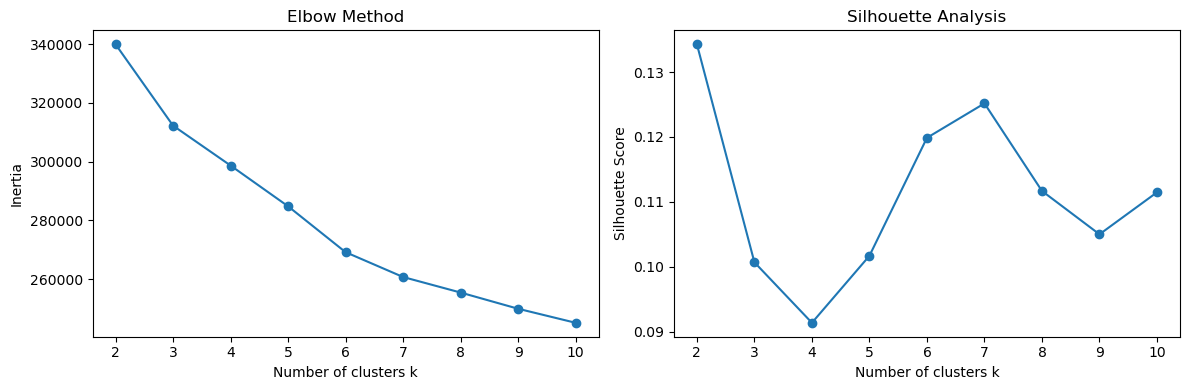

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [17]:
exclude_cols = ['CustomerID', 'TransactionDate']
encoded_features = [col for col in retail_onehot.columns if col not in exclude_cols]

df_segmented = kmeans_clustering(
    retail_onehot,
    encoded_features,
    n_clusters=7,
    eval_range=(2, 10)
)

In [19]:
df_segmented.head()

,CustomerID,Quantity,Price,TransactionDate,DiscountApplied(%),TotalAmount,Competitor Price,ProductID_A,ProductID_B,ProductID_C,...,PaymentMethod_Credit Card,PaymentMethod_Debit Card,PaymentMethod_PayPal,ProductCategory_Books,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Home Decor,Seasonal Factor_High,Seasonal Factor_Medium,Segment
75721,589267,9,39.435470,2023-12-25 08:52:00,4.133846,340.247412,42.73,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2
80184,984728,5,30.725078,2024-04-04 19:47:00,10.191359,137.968874,31.19,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2
19864,843790,3,52.491217,2024-03-07 16:39:00,11.401557,139.519204,50.55,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4
76699,9344,6,79.395876,2024-04-16 15:38:00,10.308317,427.268985,82.58,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5
92991,92751,7,95.561580,2024-03-18 04:21:00,7.499713,618.763148,107.07,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3


In [23]:
# merge to the reatil_df
retail_df = retail_df.merge(df_segmented[['CustomerID', 'Segment']], on='CustomerID', how='left')
retail_df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,ProductCategory,DiscountApplied(%),TotalAmount,Competitor Price,Seasonal Factor,Segment
0,589267,B,9,39.435470,2023-12-25 08:52:00,Credit Card,Clothing,4.133846,340.247412,42.73,High,2
1,984728,B,5,30.725078,2024-04-04 19:47:00,PayPal,Clothing,10.191359,137.968874,31.19,High,2
2,843790,C,3,52.491217,2024-03-07 16:39:00,Credit Card,Books,11.401557,139.519204,50.55,Medium,4
3,9344,D,6,79.395876,2024-04-16 15:38:00,Debit Card,Electronics,10.308317,427.268985,82.58,High,5
4,92751,D,7,95.561580,2024-03-18 04:21:00,PayPal,Clothing,7.499713,618.763148,107.07,Medium,3


In [25]:
# estimate elasticity per Segment & Product Category
def estimate_elasticity(df):
    mask = (df['Quantity'] > 0) & (df['Price'] > 0)
    if mask.sum() < 10:
        return pd.Series({'Elasticity': np.nan})

    log_q = np.log(df.loc[mask, 'Quantity'])
    log_p = np.log(df.loc[mask, 'Price'])
    X = sm.add_constant(log_p)
    model = sm.OLS(log_q, X).fit()
    return pd.Series({'Elasticity': model.params[1]})
  
elasticity_by_segment = retail_df.groupby(['Segment', 'ProductCategory']).apply(estimate_elasticity).reset_index()

In [27]:
# merge to the reatail_df with elasticity score
retail_df = retail_df.merge(elasticity_by_segment[['Segment', 'ProductCategory','Elasticity']],on=['Segment', 'ProductCategory'], how='left')
retail_df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,ProductCategory,DiscountApplied(%),TotalAmount,Competitor Price,Seasonal Factor,Segment,Elasticity
0,589267,B,9,39.435470,2023-12-25 08:52:00,Credit Card,Clothing,4.133846,340.247412,42.73,High,2,-0.331421
1,984728,B,5,30.725078,2024-04-04 19:47:00,PayPal,Clothing,10.191359,137.968874,31.19,High,2,-0.331421
2,843790,C,3,52.491217,2024-03-07 16:39:00,Credit Card,Books,11.401557,139.519204,50.55,Medium,4,-0.219784
3,9344,D,6,79.395876,2024-04-16 15:38:00,Debit Card,Electronics,10.308317,427.268985,82.58,High,5,-0.728344
4,92751,D,7,95.561580,2024-03-18 04:21:00,PayPal,Clothing,7.499713,618.763148,107.07,Medium,3,-0.207832


In [29]:
retail_df.describe()

,CustomerID,Quantity,Price,DiscountApplied(%),TotalAmount,Competitor Price,Segment,Elasticity
count,20376.000000,20376.000000,20376.000000,20376.000000,20376.000000,20376.000000,20376.000000,20376.000000
mean,501432.797114,5.006576,54.916245,10.045141,247.386494,54.918382,2.923979,-0.272272
std,288024.579988,2.582177,25.976289,5.782451,184.791218,26.697572,2.056040,0.173186
min,14.000000,1.000000,10.005120,0.000046,8.274825,7.790000,0.000000,-0.907865
25%,253053.000000,3.000000,32.384860,5.030637,94.617822,31.895000,1.000000,-0.256854
50%,504232.000000,5.000000,54.782487,10.017968,198.471404,54.270000,3.000000,-0.219784
75%,751680.500000,7.000000,77.273781,15.059069,359.589744,76.520000,5.000000,-0.195874
max,999997.000000,9.000000,99.998469,19.998595,895.343955,129.660000,6.000000,0.546803


In [31]:
retail_df['Treatment'] = (retail_df['DiscountApplied(%)'] > 1).astype(int) # set the cutoff to 1 

In [33]:
retail_df['Treatment'].value_counts(normalize=True)

1    0.951315
0    0.048685
Name: Treatment, dtype: float64

In [35]:
print("Mean outcome (control):", retail_df.loc[retail_df.Treatment==0, 'TotalAmount'].mean())
print("Mean outcome (treated):", retail_df.loc[retail_df.Treatment==1, 'TotalAmount'].mean())


Mean outcome (control): 271.30636959783266
Mean outcome (treated): 246.16236541257769


In [37]:
# evaluate uplift(%)
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample 

def compute_uplift_by_segment(
    df,
    feature_cols,
    categorical_cols,
    treatment_col='Treatment',
    outcome_col='TotalAmount',
    group_cols=['Segment','ProductCategory'],
    imbalance_method='resample',      
    random_state=42,
    drop_first=True
):

     df_work = df.copy()
     df_work[treatment_col] = df_work[treatment_col].astype(int)
     df_work['Outcome'] = df_work[outcome_col]
     
     model_df = pd.get_dummies(
        df_work[feature_cols + categorical_cols + [treatment_col, 'Outcome']],
        drop_first=drop_first
    )

     X_full = model_df.drop(columns=['Outcome', treatment_col])
     y_full = model_df['Outcome']
     T_full = model_df[treatment_col]

     if imbalance_method == 'resample':
        # split treated / control
        X_t  = X_full[T_full == 1]
        y_t  = y_full[T_full == 1]
        X_c  = X_full[T_full == 0]
        y_c  = y_full[T_full == 0]

        # decide which is minority
        if len(X_t) > len(X_c):
            X_c, y_c = resample(
                X_c, y_c,
                replace=True,
                n_samples=len(X_t),
                random_state=random_state
            )
        else:
            X_t, y_t = resample(
                X_t, y_t,
                replace=True,
                n_samples=len(X_c),
                random_state=random_state
            )
     else:
        # no resampling
        X_t  = X_full[T_full == 1]
        y_t  = y_full[T_full == 1]
        X_c  = X_full[T_full == 0]
        y_c  = y_full[T_full == 0]

    # 5. Fit one model per group
     lr_treat   = LinearRegression().fit(X_t, y_t)
     lr_control = LinearRegression().fit(X_c, y_c)

    # 6. Predict on the full dataset
     y_pred_treat   = lr_treat.predict(X_full)
     y_pred_control = lr_control.predict(X_full)

    # 7. Attach uplift back to original df
     df_out = df_work.copy()
     df_out['Uplift Score'] = y_pred_treat - y_pred_control

    # 8. Aggregate summary
     uplift_summary = (
        df_out
        .groupby(group_cols)['Uplift Score']
        .mean()
        .reset_index()
        .sort_values('Uplift Score', ascending=False)
    )

     return df_out, uplift_summary

In [39]:
feature_cols      = ['Price','Competitor Price','Elasticity']
categorical_cols  = ['ProductCategory','Seasonal Factor']

df_with_uplift, upl_summary = compute_uplift_by_segment(
    retail_df,
    feature_cols,
    categorical_cols,
    treatment_col='Treatment',
    outcome_col='TotalAmount',
    group_cols=['Segment','ProductCategory'],
    imbalance_method='resample'  
)

print(upl_summary)


    Segment ProductCategory  Uplift Score
10        2     Electronics    -12.631961
20        5           Books    -16.424748
2         0     Electronics    -17.298924
8         2           Books    -18.309948
27        6      Home Decor    -18.547480
16        4           Books    -19.159648
22        5     Electronics    -20.704680
26        6     Electronics    -22.057194
7         1      Home Decor    -22.520884
19        4      Home Decor    -23.783465
3         0      Home Decor    -24.206131
11        2      Home Decor    -24.225191
5         1        Clothing    -28.518077
9         2        Clothing    -28.759195
25        6        Clothing    -28.845762
6         1     Electronics    -29.374026
23        5      Home Decor    -36.752448
0         0           Books    -37.107347
21        5        Clothing    -37.288402
1         0        Clothing    -37.718480
12        3           Books    -40.189670
14        3     Electronics    -42.520728
4         1           Books    -43

In [43]:
# Compute ipw up
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression

def compute_ipw_uplift(
    df: pd.DataFrame,
    feature_cols: list,
    categorical_cols: list,
    treatment_col: str = 'Treatment',
    outcome_col: str = 'TotalAmount',
    group_cols: list = None,
    random_state: int = 42,
    drop_first: bool = True
) -> (pd.DataFrame, pd.DataFrame):

    if group_cols is None:
        group_cols = ['Segment', 'ProductCategory']
    
    # 1. Prepare data
    df_work = df.copy()
    df_work[treatment_col] = df_work[treatment_col].astype(int)
    df_work['Y'] = df_work[outcome_col]
    
    # 2. Build design matrix for propensity model
    X_ps = pd.get_dummies(df_work[feature_cols + categorical_cols], drop_first=drop_first)
    T = df_work[treatment_col]
    
    # 3. Fit propensity model
    ps_model = LogisticRegression(max_iter=1000, random_state=random_state)
    df_work['ps'] = ps_model.fit(X_ps, T).predict_proba(X_ps)[:, 1]
    
    # 4. Compute IPW weights
    df_work['w'] = np.where(T == 1, 1 / df_work['ps'], 1 / (1 - df_work['ps']))
    
    # 5. Build interaction model design
    X_base = X_ps.copy()
    scaler = StandardScaler()
    # Interaction terms
    X_int = X_base.mul(T, axis=0).add_suffix('_x_T')
    X_design = pd.concat([X_base, T.rename('T'), X_int], axis=1)
    
    # 6. Fit weighted linear model
    lm = LinearRegression()
    lm.fit(X_design, df_work['Y'], sample_weight=df_work['w'])
    
    # 7. Counterfactual predictions
    # Control case
    X_ctrl = X_design.copy()
    X_ctrl['T'] = 0
    for col in X_int.columns:
        X_ctrl[col] = 0
    # Treated case
    X_trt = X_design.copy()
    X_trt['T'] = 1
    
    y_ctrl = lm.predict(X_ctrl)
    y_trt = lm.predict(X_trt)
    
    # 8. Compute IPW uplift
    df_out = df_work.copy()
    df_out['uplift_ipw'] = y_trt - y_ctrl
    
    # 9. Summary by groups
    summary = (
        df_out
        .groupby(group_cols)['uplift_ipw']
        .mean()
        .reset_index()
        .sort_values('uplift_ipw', ascending=False)
    )
    
    return df_out, summary




In [45]:
df_ipw, ipw_summary = compute_ipw_uplift(
    retail_df,
    feature_cols=['Price','Competitor Price','Elasticity'],
    categorical_cols=['ProductCategory','Seasonal Factor']
)
print(ipw_summary)

    Segment ProductCategory  uplift_ipw
20        5           Books  -11.944733
8         2           Books  -13.874068
10        2     Electronics  -14.022589
27        6      Home Decor  -17.490774
16        4           Books  -17.753726
11        2      Home Decor  -21.148931
2         0     Electronics  -21.687934
3         0      Home Decor  -22.328016
7         1      Home Decor  -22.392535
22        5     Electronics  -22.475579
19        4      Home Decor  -23.800894
26        6     Electronics  -25.167101
9         2        Clothing  -26.077517
5         1        Clothing  -28.537901
25        6        Clothing  -29.209326
23        5      Home Decor  -34.402125
6         1     Electronics  -34.920453
21        5        Clothing  -34.970853
0         0           Books  -36.594258
1         0        Clothing  -37.761627
12        3           Books  -39.797883
4         1           Books  -40.609136
15        3      Home Decor  -45.201176
14        3     Electronics  -47.451618


In [57]:
import pandas as pd
import numpy as np
from econml.dml import CausalForestDML, LinearDML
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

def compute_causal_forest_uplift(
    df: pd.DataFrame,
    feature_cols: list,
    categorical_cols: list,
    treatment_col: str = 'Treatment',
    outcome_col: str = 'TotalAmount',
    group_cols: list = None,
    random_state: int = 42
):
   
    if group_cols is None:
        group_cols = ['Segment', 'ProductCategory']
    
    # 1. Encode features
    X_num = df[feature_cols].fillna(0)
    X_cat = pd.get_dummies(df[categorical_cols], drop_first=True) if categorical_cols else pd.DataFrame()
    X = pd.concat([X_num, X_cat], axis=1) if not X_cat.empty else X_num
    
    # 2. Prepare treatment and outcome variables
    T = df[treatment_col].values
    Y = df[outcome_col].values
    
    # Determine if T is binary or continuous
    unique_values = np.unique(T)
    is_binary = len(unique_values) <= 2
    
    # 3. Create appropriate models based on treatment type
    if is_binary:
        # For binary treatment
        print(f"Treatment is binary with values: {unique_values}")
        model_t = LogisticRegression(max_iter=1000, solver='lbfgs')
        # Convert treatment to binary (0/1)
        T = (T == T.max()).astype(int)
    else:
        # For continuous treatment
        print(f"Treatment is continuous with {len(unique_values)} unique values")
        model_t = RandomForestRegressor(n_estimators=100, random_state=random_state)
    
    model_y = RandomForestRegressor(n_estimators=100, random_state=random_state)
    
    try:
        # 4. First try with CausalForestDML
        print("Attempting CausalForestDML...")
        est = CausalForestDML(
            model_y=model_y,
            model_t=model_t,
            n_estimators=100,
            min_samples_leaf=10,
            random_state=random_state,
            discrete_treatment=is_binary
        )
        est.fit(Y, T, X=X)
        
    except Exception as e:
        print(f"CausalForestDML failed with error: {str(e)}")
        print("Falling back to LinearDML...")
        
        # 5. Fallback to LinearDML if CausalForestDML fails
        est = LinearDML(
            model_y=model_y,
            model_t=model_t,
            random_state=random_state,
            discrete_treatment=is_binary
        )
        est.fit(Y, T, X=X)
    
    # 6. Estimate individual treatment effects
    uplift = est.effect(X)
    
    # 7. Add uplift to original dataframe
    df_out = df.copy()
    df_out['uplift_cf'] = uplift
    
    # 8. Generate summary by group
    summary = (
        df_out
        .groupby(group_cols)['uplift_cf']
        .agg(['mean', 'count', 'std'])
        .reset_index()
        .sort_values('mean', ascending=False)
    )
    
    return df_out, summary

In [59]:
df_cf, cf_summary = compute_causal_forest_uplift(
    retail_df,
    feature_cols=['Price', 'Competitor Price', 'Elasticity'],
    categorical_cols=['ProductCategory', 'Seasonal Factor']
)
print(cf_summary)

Treatment is binary with values: [0 1]
Attempting CausalForestDML...
    Segment ProductCategory       mean  count        std
19        4      Home Decor  -7.338203     12  36.259135
10        2     Electronics  -9.838397    657  24.640049
2         0     Electronics -10.966966   3219  33.964391
11        2      Home Decor -12.400454    681  27.001000
12        3           Books -13.491413    700  38.547202
9         2        Clothing -13.648232    644  24.058223
14        3     Electronics -13.837756    593  39.196834
7         1      Home Decor -14.246726   3161  32.957782
24        6           Books -15.141979     12  29.532004
16        4           Books -15.859701   3081  33.647530
8         2           Books -16.208539    741  25.201528
20        5           Books -16.866342    579  53.777313
4         1           Books -19.638330     14  33.915151
27        6      Home Decor -21.023750     21  21.436839
0         0           Books -22.052020     19  24.933867
1         0        

In [61]:
# merge back to retail_df
uplift_summary_renamed = cf_summary.rename(columns={'mean': 'Avg_Uplift_Score'})
retail_df = retail_df.merge(uplift_summary_renamed[['Segment', 'ProductCategory', 'Avg_Uplift_Score']], 
                           on=['Segment', 'ProductCategory'], 
                           how='left')
retail_df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,ProductCategory,DiscountApplied(%),TotalAmount,Competitor Price,Seasonal Factor,Segment,Elasticity,Treatment,Avg_Uplift_Score
0,589267,B,9,39.435470,2023-12-25 08:52:00,Credit Card,Clothing,4.133846,340.247412,42.73,High,2,-0.331421,1,-13.648232
1,984728,B,5,30.725078,2024-04-04 19:47:00,PayPal,Clothing,10.191359,137.968874,31.19,High,2,-0.331421,1,-13.648232
2,843790,C,3,52.491217,2024-03-07 16:39:00,Credit Card,Books,11.401557,139.519204,50.55,Medium,4,-0.219784,1,-15.859701
3,9344,D,6,79.395876,2024-04-16 15:38:00,Debit Card,Electronics,10.308317,427.268985,82.58,High,5,-0.728344,1,-22.583072
4,92751,D,7,95.561580,2024-03-18 04:21:00,PayPal,Clothing,7.499713,618.763148,107.07,Medium,3,-0.207832,1,-25.002847


In [65]:
retail_df.to_csv('retail_uplift_causalforestDML.csv', index=False)

In [67]:
# create dimensional table for BI 
retail_df['TransactionDate'] = pd.to_datetime(retail_df['TransactionDate'])
dim_time = retail_df[['TransactionDate']].drop_duplicates()
dim_time['Year'] = dim_time['TransactionDate'].dt.year
dim_time['Month'] = dim_time['TransactionDate'].dt.month
dim_time['Day'] = dim_time['TransactionDate'].dt.day
dim_time['Weekday'] = dim_time['TransactionDate'].dt.day_name()
dim_time.to_csv('dim_time.csv', index=False)